In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
def get_smoothed(losses: list, steps: list, window_size: int):
    smoothed_losses = [
        np.mean(losses[i:i + window_size]) 
        for i in range(0, len(losses) - window_size + 1, window_size)
    ]
    smoothed_steps = [
        steps[i + window_size // 2] 
        for i in range(0, len(steps) - window_size + 1, window_size)
    ]
    return smoothed_losses, smoothed_steps

In [3]:
def get_metrics(log_file):
    with open(log_file, "r", encoding="utf8") as file:
        text = file.read()
    pattern = r"MRR: ([\de\.\-]+) \| Hit Rate @ 1: ([\de\.\-]+)\n.+\s(\d+)/4000"
    blocks = re.findall(pattern, text)
    steps = [int(step) for _, _, step in blocks]
    mrr = [float(mrr) for mrr, _, _ in blocks]
    hr = [float(hr) for _, hr, _ in blocks]
    return steps, mrr, hr


def get_losses(log_file):
    with open(log_file, "r", encoding="utf8") as file:
        text = file.read()

    pattern = r"Training:\s+\d+%\|.*?\|\s+(\d+)/4000.*?loss=([\de\.\-]+)"
    blocks = re.findall(pattern, text)

    steps = [int(step) for step, loss in blocks]
    losses = [float(loss) for step, loss in blocks]

    window_size = 16 # 8 accumulation steps, 2 steps for batch size
    smoothed_losses, smoothed_steps = get_smoothed(losses, steps, window_size)

    return smoothed_steps, smoothed_losses

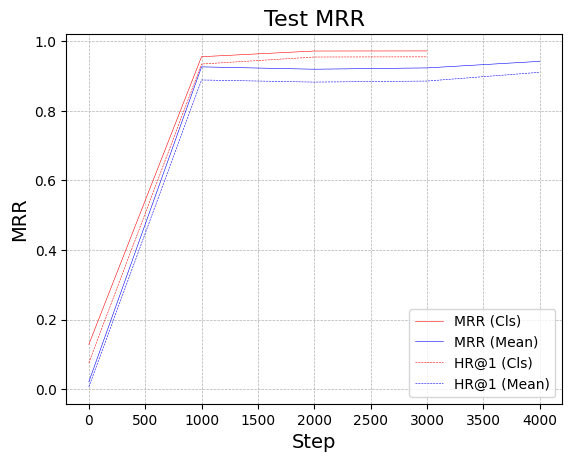

In [7]:
cls_steps, cls_mrr, cls_hr = get_metrics("gemma-cls.log")
mean_steps, mean_mrr, mean_hr = get_metrics("gemma-mean.log")

plt.plot(cls_steps, cls_mrr, linestyle='-', color='r', linewidth=0.4, label='MRR (Cls)')
plt.plot(mean_steps, mean_mrr, linestyle='-', color='b', linewidth=0.4, label='MRR (Mean)')

plt.plot(cls_steps, cls_hr, linestyle='--', color='r', linewidth=0.4, label='HR@1 (Cls)')
plt.plot(mean_steps, mean_hr, linestyle='--', color='b', linewidth=0.4, label='HR@1 (Mean)')

plt.xlabel("Step", fontsize=14)
plt.ylabel("MRR", fontsize=14)
plt.title("Test MRR", fontsize=16)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

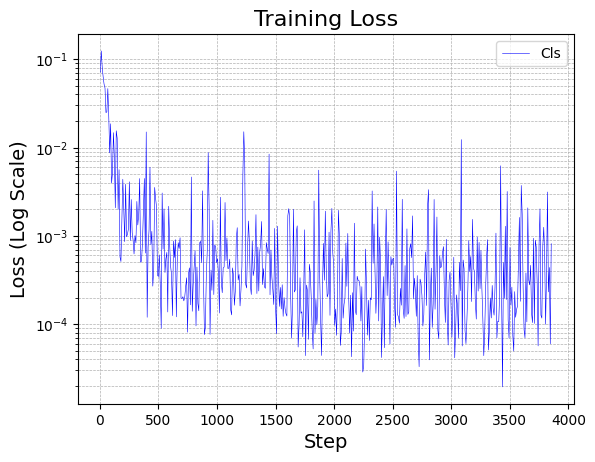

In [5]:
cls_steps, cls_losses = get_losses("gemma-cls.log")
mean_steps, mean_losses = get_losses("gemma-mean.log")

plt.plot(cls_steps, cls_losses, linestyle='-', color='b', linewidth=0.4, label='Cls')
# plt.plot(mean_steps, mean_losses, linestyle='-', color='r', linewidth=0.4, label='Loss')

plt.yscale('log')
plt.xlabel("Step", fontsize=14)
plt.ylabel("Loss (Log Scale)", fontsize=14)
plt.title("Training Loss", fontsize=16)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()
